In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [92]:
class EpsilonGreedyAlgorithm:
    def __init__(self,true_probs,epsilon) -> None:
        self.true_probs = true_probs
        self.n = len(true_probs)
        self.emperical_probs = np.array([0.5 for _ in range(len(true_probs))])
        self.tries = np.array([1 for _ in range(len(true_probs))])
        self.wins = np.array([1 for _ in range(len(true_probs))])
        self.epsilon = epsilon
        self.timeline_probs_ = None

    def select_arm(self) -> int:
        if np.random.random() <= self.epsilon:
            indecies = list(range(self.n))
        else:
            max_prob = np.max(self.emperical_probs)
            indecies =  [i for i,prob in enumerate(self.emperical_probs) if prob == max_prob]
        return np.random.choice(indecies)
    
    def try_arm_and_update(self, arm_index):
        reward = int(np.random.random() <= self.true_probs[arm_index])
        self.tries[arm_index] = self.tries[arm_index] + 1
        self.wins[arm_index] = self.wins[arm_index] + reward
        self.emperical_probs[arm_index] = self.wins[arm_index]/self.tries[arm_index]
        return reward
    
    def run(self, iterations):
        probs_timeline = []
        for _ in range(iterations):
            arm = self.select_arm()
            self.try_arm_and_update(arm)
            probs_timeline.append(self.emperical_probs.copy())
        self.timeline_probs_ = np.array(probs_timeline)


In [2]:
def plot_timeline_probs(history):
    for i in range(history.shape[1]):
        plt.plot(range(history.shape[0]),history[:,i],label=f'Arm {i+1}')
    plt.ylim = (0,1)
    plt.legend()
    plt.show()

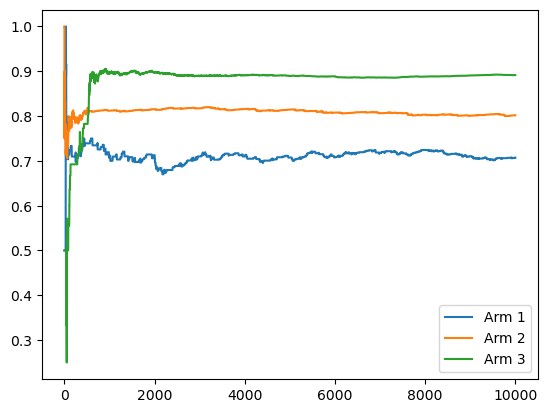

In [155]:
algo = EpsilonGreedyAlgorithm([0.7,0.8,0.9],epsilon=0.1)
algo.run(10000)
plot_timeline_probs(algo.timeline_probs_)

In [90]:
from scipy.stats import beta

class ThompsonBernoulliAlgorithm:
    def __init__(self,true_probs) -> None:
        self.true_probs = true_probs
        self.n = len(true_probs)
        self.alphas = np.array([1 for _ in range(len(true_probs))])
        self.betas = np.array([1 for _ in range(len(true_probs))])
        self.timeline_probs_ = None

    def select_arm(self) -> int:
        probs = [beta(a = a,b= b).rvs() for a,b in zip(self.alphas,self.betas)]
        self.timeline_probs_.append(probs.copy())
        max_prob = np.max(probs)
        indecies =  [i for i,prob in enumerate(probs) if prob == max_prob]
        return np.random.choice(indecies)
    
    def try_arm_and_update(self, arm_index):
        reward = int(np.random.random() <= self.true_probs[arm_index])
        self.betas[arm_index] = self.betas[arm_index] + 1 - reward
        self.alphas[arm_index] = self.alphas[arm_index] + reward
        return reward
    
    def run(self, iterations):
        self.timeline_probs_ = []
        for _ in range(iterations):
            arm = self.select_arm()
            self.try_arm_and_update(arm)
        self.timeline_probs_ = np.array(self.timeline_probs_)


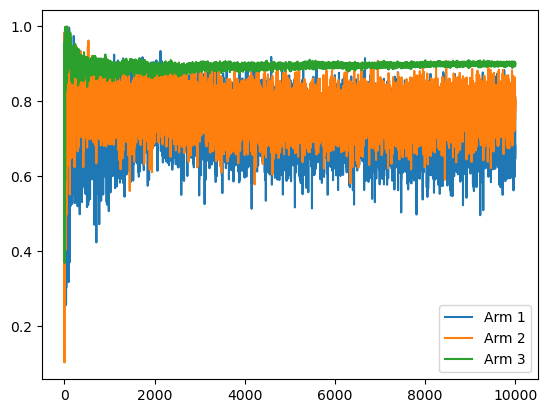

In [91]:
algo = ThompsonBernoulliAlgorithm([0.7,0.8,0.9])
algo.run(10000)
plot_timeline_probs(algo.timeline_probs_)

In [14]:
from scipy.stats import norm

class UCBGaussianAlgorithm:
    def __init__(self,true_means,true_variances) -> None:
        self.n = len(true_means)
        self.true_means = true_means
        self.true_precisions = 1 / np.array(true_variances)

        self.empirical_means = [norm.rvs(loc=mean,scale=1) for mean in self.true_means]
        self.emperical_precisions = np.full((1,self.n), 1.0).ravel()
        self.arms_tries = np.full((1,self.n),1).ravel()
        
        self.timeline_means_ = []
        self.timeline_ucbs_ = []

    def select_arm(self) -> int:
        ucbs = self.empirical_means + np.sqrt(2 * np.log(np.sum(self.arms_tries))/self.arms_tries)
        self.timeline_means_.append(self.empirical_means.copy())
        self.timeline_ucbs_.append(ucbs.copy())
        max_ucb = np.max(ucbs)
        indices =  [i for i,ucb in enumerate(ucbs) if ucb == max_ucb]
        return np.random.choice(indices)
    
    def try_arm_and_update(self, arm_index):
        mean = self.empirical_means[arm_index]
        precision = self.emperical_precisions[arm_index]
        true_mean = self.true_means[arm_index]
        true_precision = self.true_precisions[arm_index]
        reward = norm.rvs(loc=true_mean,scale=1/true_precision)
        self.empirical_means[arm_index] = (precision * mean + true_precision * reward) / (precision + true_precision)
        self.emperical_precisions[arm_index] = 1 / (precision + true_precision)
        self.arms_tries[arm_index] += 1
        return reward
    
    def run(self, iterations):
        for _ in range(iterations):
            arm = self.select_arm()
            self.try_arm_and_update(arm)
        self.timeline_means_ = np.array(self.timeline_means_)
        self.timeline_ucbs_ = np.array(self.timeline_ucbs_)


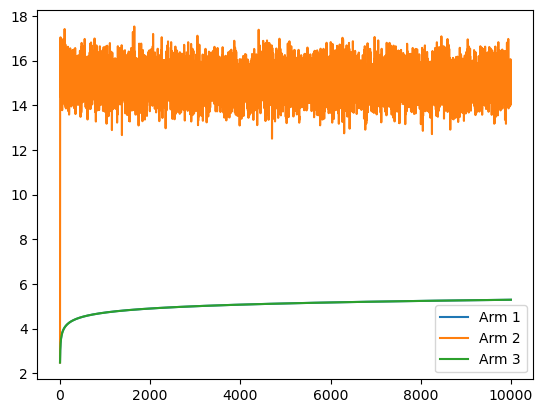

In [15]:
algo = UCBGaussianAlgorithm([10,15,20],[1,1,1])
algo.run(10000)
plot_timeline_probs(algo.timeline_ucbs_)

In [18]:
from scipy.stats import norm

class ThompsonGaussianAlgorithm:
    def __init__(self,true_means,true_variances) -> None:
        self.n = len(true_means)
        self.true_means = true_means
        self.true_precisions = 1 / np.array(true_variances)

        self.empirical_means = [norm.rvs(loc=mean,scale=1) for mean in self.true_means]
        self.emperical_precisions = np.full((1,self.n), 1.0).ravel()
        
        self.timeline_means_ = []

    def select_arm(self) -> int:
        means = [norm.rvs(loc=mean,scale=1/precision) for mean, precision in zip(self.empirical_means, self.emperical_precisions)]
        self.timeline_means_.append(self.empirical_means.copy())
        max_mean = np.max(means)
        indices =  [i for i,mean in enumerate(means) if mean == max_mean]
        return np.random.choice(indices)
    
    def try_arm_and_update(self, arm_index):
        mean = self.empirical_means[arm_index]
        precision = self.emperical_precisions[arm_index]
        true_mean = self.true_means[arm_index]
        true_precision = self.true_precisions[arm_index]
        reward = norm.rvs(loc=true_mean,scale=1/true_precision)
        self.empirical_means[arm_index] = (precision * mean + true_precision * reward) / (precision + true_precision)
        self.emperical_precisions[arm_index] = 1 / (precision + true_precision)
        return reward
    
    def run(self, iterations):
        for _ in range(iterations):
            arm = self.select_arm()
            self.try_arm_and_update(arm)
        self.timeline_means_ = np.array(self.timeline_means_)


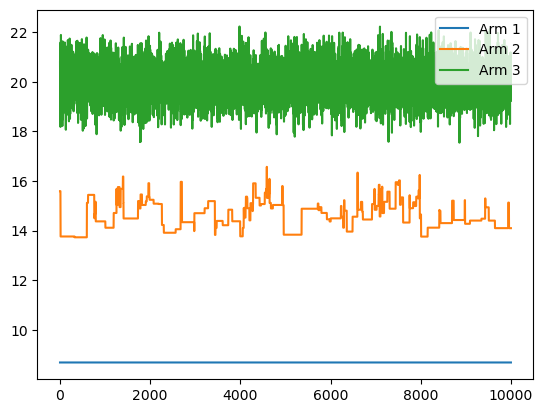

In [19]:
algo = ThompsonGaussianAlgorithm([10,15,20],[1,1,1])
algo.run(10000)
plot_timeline_probs(algo.timeline_means_)